# Imports

In [2]:
# Math
import torch
import numpy as np

# Flair Device
import flair
flair.device = torch.device('cpu')

# Analysis
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

# Downloading Packages
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Autoencoder and Dataset Preparation
from data.imdb_preparation import IMDB_preparation
from data.ag_news_preparation import AG_NEWS_preparation
from autoencoders.autoencoder import Autoencoder

[nltk_data] Downloading package punkt to /home/bodo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bodo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/bodo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/bodo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/bodo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. VAE

## 2.1 Loading Data

In [2]:
ds = AG_NEWS_preparation()
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)

/home/bodo/.local/lib/python3.8/site-packages/torch/utils/data/datapipes/utils/common.py:24: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn(


Preparing sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [03:19<00:00, 602.96it/s]


Making sentences...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [00:50<00:00, 2395.36it/s]


Embedding sentences...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [00:28<00:00, 4198.04it/s]


Splitting sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [00:06<00:00, 19151.07it/s]

Done!


In [3]:
ds_train, ds_valid = torch.utils.data.random_split(ds, [len(ds) - 1000, 1000])
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, shuffle=True)

## 2.2 Training loop

In [22]:
m = Autoencoder(100,100,100,4,1,variational=True,max_log2len=8)
Lsmse = []
Lsvar = []
Ls_train = []
Ls_valid = []
device = 'cuda'
m = m.to(device)

In [29]:
opt = torch.optim.Adamax(m.parameters(), lr=0.001, weight_decay=0.0001)

In [30]:
EPOCHS = 6
beta = 0.1
for e in range(EPOCHS):
    print(f"Epoch: {e}")
    pbar = tqdm(dl_train)
    m = m.train()
    for i, (x_in, x_out) in enumerate(pbar):
        opt.zero_grad()
        x_in = x_in.to(device)
        x_out = x_out.to(device)
        mx, (mu, logvar) = m(x_in, return_Z=True)
        Lmse = (mx - x_out).pow(2).sum((1,2)).mean()
        Lvar = - 0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum((1,2)).mean()
        L = Lmse + beta*Lvar
        L.backward()
        opt.step()
    
        pbar.set_description(f"L: {L.item()} Lmse: {Lmse.item()} Lvar: {Lvar.item()}")
        
        Lsmse.append(Lmse.item())
        Lsvar.append(Lvar.item())
        Ls_train.append(L.item())
    with torch.no_grad():
        m = m.eval()
        pbar = tqdm(dl_valid)
        for i, (x_in, x_out) in enumerate(pbar):
            x_in = x_in.to(device)
            x_out = x_out.to(device)
            mx = m(x_in)
            L = (mx - x_out).pow(2).sum((1,2)).mean()
            pbar.set_description(f"VL: {L.item()}")
            Ls_valid.append(L.item())

Epoch: 0


L: 220.0059814453125 Lmse: 213.81625366210938 Lvar: 61.897216796875: 100%|██████████████████████████████████████████████████████████████| 9350/9350 [04:59<00:00, 31.21it/s]
VL: 246.0740966796875: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 99.58it/s]


Epoch: 1


L: 221.55567932128906 Lmse: 215.1577911376953 Lvar: 63.97892379760742: 100%|████████████████████████████████████████████████████████████| 9350/9350 [05:46<00:00, 26.95it/s]
VL: 223.81729125976562: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 76.65it/s]


Epoch: 2


L: 216.99972534179688 Lmse: 210.79855346679688 Lvar: 62.0117073059082: 100%|████████████████████████████████████████████████████████████| 9350/9350 [06:10<00:00, 25.21it/s]
VL: 220.7137451171875: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 90.69it/s]


Epoch: 3


L: 211.16978454589844 Lmse: 204.65740966796875 Lvar: 65.12374877929688: 100%|███████████████████████████████████████████████████████████| 9350/9350 [05:43<00:00, 27.26it/s]
VL: 197.15171813964844: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 79.98it/s]


Epoch: 4


L: 229.67266845703125 Lmse: 222.82968139648438 Lvar: 68.429931640625: 100%|█████████████████████████████████████████████████████████████| 9350/9350 [05:46<00:00, 26.98it/s]
VL: 224.63221740722656: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 83.99it/s]


Epoch: 5


L: 203.6675262451172 Lmse: 196.59043884277344 Lvar: 70.7708740234375: 100%|█████████████████████████████████████████████████████████████| 9350/9350 [06:01<00:00, 25.86it/s]
VL: 181.89967346191406: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 59.90it/s]


In [31]:
torch.save(({'train': Ls_train, 'valid':Ls_valid, 'mse': Lsmse, 'var': Lsvar}, m.state_dict()), f'vae_small_9_AG.pt')

For AG_NEWS dataset, the training curves look similar to the ones described in the IMDB section. The overall loss is mostly comprised of the MSE loss. The variational loss is much lower in comparison. The overall loss is being minimised very slowly.

The validation loss matches the training loss:

In [3]:
losses, _ = torch.load('vae_small_9_AG.pt')

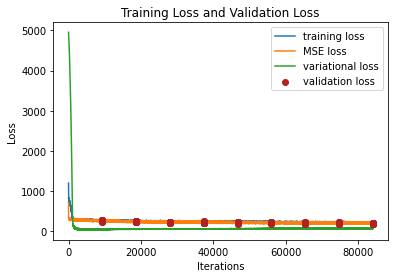

In [4]:
plt.plot(losses['train'], label='training loss')
plt.plot(losses['mse'], label='MSE loss')
plt.plot(losses['var'], label='variational loss')
for i in range(9):
    plt.scatter(
        [(i+1)*9349 for _ in range(32)],
        losses['valid'][i*32:(i+1)*32],
        zorder=2,
        c='firebrick',
        label='validation loss' if i == 0 else ''
    )
plt.title('Training Loss and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()